In [1]:
import os
import sys
import gc
import time
import warnings
import pickle
import random
import statistics


import numpy as np
import pandas as pd
from tqdm import tqdm
import dataclasses
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psutil
from google.cloud import storage, bigquery
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import transformers
import torch
from statsforecast.models import (
    AutoETS
)
from statsforecast import StatsForecast
from sklearn.metrics import mean_squared_error


from timesfm import patched_decoder, data_loader
import timesfm as tfm


# import jax
# from jax import numpy as jnp
# from praxis import (
#     pax_fiddle, py_utils, pytypes, base_model, optimizers, schedules,
#     base_hyperparams, base_layer
# )
# from paxml import (
#     tasks_lib, trainer_lib, checkpoints, learners,
#     partitioning, checkpoint_types
# )
# warnings.filterwarnings("ignore", category=FutureWarning)



# Matplotlib Settings
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Pandas Display Settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Initialize Google BigQuery Client
client = bigquery.Client()

# Seed Settings for Reproducibility
np.random.seed(2)
random.seed(2)
torch.manual_seed(2)
# transformers.set_seed(2)


TimesFM v1.2.0. See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded Jax TimesFM.


In [2]:
def generate_one_seasonal_series(
    start_date='2018-01',
    periods=45,
    p_increasing=0.95,
    base_oct=50.0,    # October baseline
    base_nov=520.0,    # November (peak) baseline
    base_dec=310.0,    # December baseline
    base_off=0.0,      # Off-season baseline
    additive_noise_scale=10.0,
    multiplicative_noise_scale=0.2,
    poisson_lam=1,
    random_state=None
):
    
    if random_state is not None:
        np.random.seed(random_state)
    
    # date range for 45 months
    date_index = pd.date_range(start=start_date, periods=periods, freq='MS')
    
    # Decide if this series is increasing or decreasing
    # ~95% chance to be increasing, 5% to be decreasing
    is_increasing = (np.random.rand() < p_increasing)
    
    # Generate a random 'growth' or 'shrink' factor each year
    # store a dictionary of "year -> factor"
    # For 2018 factor = 1.0
    # For subsequent years (2019, 2020, 2021) we either add or subtract some alpha each year
    # get a mild upward or downward trend in seasonal peaks.
    
    years = [2018, 2019, 2020, 2021]
    year_factor = {}
    year_factor[2018] = 1.0
    
    # random alpha ~ how strong the yearly growth is
    alpha = np.random.uniform(0.1, 0.5)
    
    # build factor for next years
    # if is_increasing: factor_{year+1} = factor_{year} + alpha
    # else: factor_{year+1} = factor_{year} - alpha
    for i in range(len(years) - 1):
        this_year = years[i]
        next_year = years[i + 1]
        if is_increasing:
            year_factor[next_year] = year_factor[this_year] + alpha
        else:
            year_factor[next_year] = max(
                0.0,  # no negative
                year_factor[this_year] - alpha
            )
    
    # multiply by the year_factor for that date's year
    seasonal_pattern = []
    for dt in date_index:
        m = dt.month
        y = dt.year
        
        if m == 10:      # October
            base_val = base_oct
        elif m == 11:    # November
            base_val = base_nov
        elif m == 12:    # December
            base_val = base_dec
        else:
            base_val = base_off
        
        # Multiply by the factor for that year
        factor = year_factor[y]
        
        seasonal_pattern.append(base_val * factor)
    
    seasonal_pattern = np.array(seasonal_pattern, dtype=float)
    
    # Additive noise
    additive_noise = np.random.normal(
        loc=0.0,
        scale=additive_noise_scale,
        size=periods
    )
    
    # Multiplicative noise
    multiplicative_noise = 1.0 + np.random.normal(
        loc=0.0,
        scale=multiplicative_noise_scale,
        size=periods
    )
    
    # Combine base pattern with noise
    series_values = (seasonal_pattern + additive_noise) * multiplicative_noise
    
    # avoid negative
    series_values = np.clip(series_values, 0, None)
    
    # Off-season months = months that are basically base_off in the pattern
    # add Poisson demands to them for more variation
    # do this prior to rounding, so the final result includes that noise
    is_off_season = (seasonal_pattern == 0)
    random_small_demands = np.random.poisson(lam=poisson_lam, size=periods)
    series_values[is_off_season] += random_small_demands[is_off_season]
    
    # Round
    series_values = series_values.round()
    
    df_single = pd.DataFrame({
        'date': date_index,
        'target': series_values
    })
    
    return df_single


def generate_many_series(
    n_series=10,
    start_date='2018-01',
    periods=45,
    p_increasing=0.95,
    base_oct=50.0,
    base_nov=520.0,
    base_dec=310.0,
    base_off=0.0,
    additive_noise_scale=10.0,
    multiplicative_noise_scale=0.2,
    poisson_lam=1
):

    all_dfs = []
    for i in range(n_series):
        df_single = generate_one_seasonal_series(
            start_date=start_date,
            periods=periods,
            p_increasing=p_increasing,
            base_oct=base_oct,
            base_nov=base_nov,
            base_dec=base_dec,
            base_off=base_off,
            additive_noise_scale=additive_noise_scale,
            multiplicative_noise_scale=multiplicative_noise_scale,
            poisson_lam=poisson_lam
        )
        
        df_single['ID'] = f'ID_{i+1}'
        all_dfs.append(df_single)
    
    df = pd.concat(all_dfs, ignore_index=True)
    df = df[['date', 'ID', 'target']]
    return df

In [3]:
df = generate_many_series(
    n_series=10000,
    start_date='2018-01',
    periods=45,
    p_increasing=0.95,  # ~95% chance to have an increasing peak
    base_oct=50,
    base_nov=520,
    base_dec=310,
    base_off=0.0,
    additive_noise_scale=10.0,
    multiplicative_noise_scale=0.2,
    poisson_lam=1
)

In [ ]:
df.head(50)

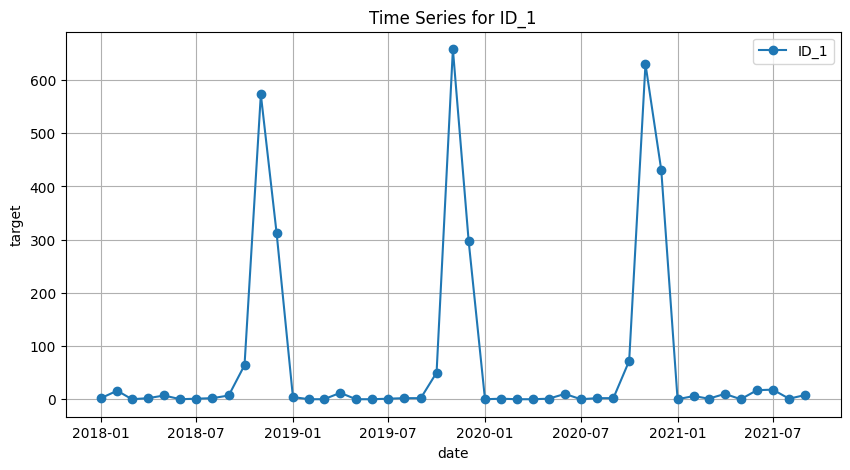

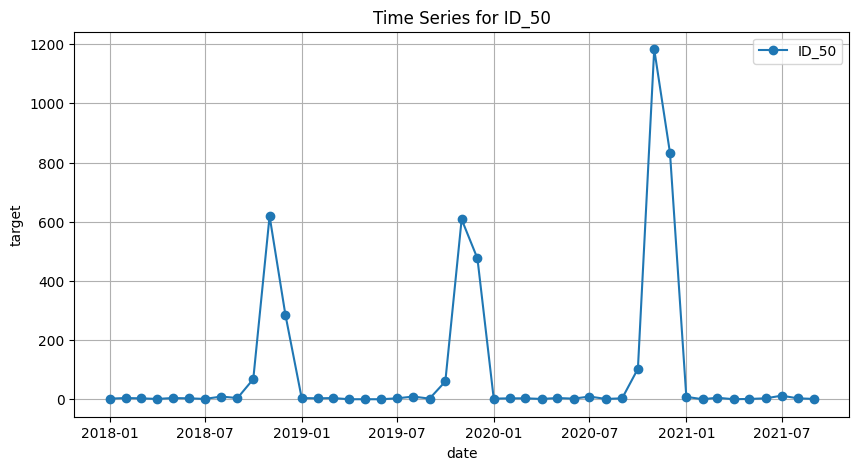

In [4]:
def plot_id(df, series_id):
    # Filter rows for the requested ID
    df_sub = df.loc[df['ID'] == series_id].copy()
    df_sub.sort_values('date', inplace=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(df_sub['date'], df_sub['target'], marker='o', label=series_id)
    plt.title(f"Time Series for {series_id}")
    plt.xlabel("date")
    plt.ylabel("target")
    plt.grid(True)
    plt.legend()
    plt.show()
    

plot_id(df, "ID_1")
plot_id(df, "ID_50")

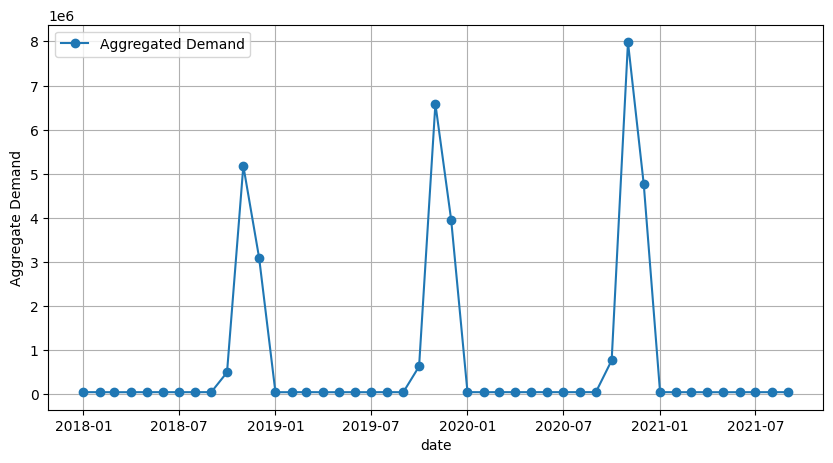

In [5]:
def plot_aggregate(df):

    aggregated_df = df.groupby('date', as_index=False)['target'].sum()
    aggregated_df.sort_values('date', inplace=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(aggregated_df['date'], aggregated_df['target'], marker='o', label='Aggregated Demand')
    plt.xlabel('date')
    plt.ylabel('Aggregate Demand')
    # plt.title('Aggregate Demand over Time (All Series Combined)')
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_aggregate(df)


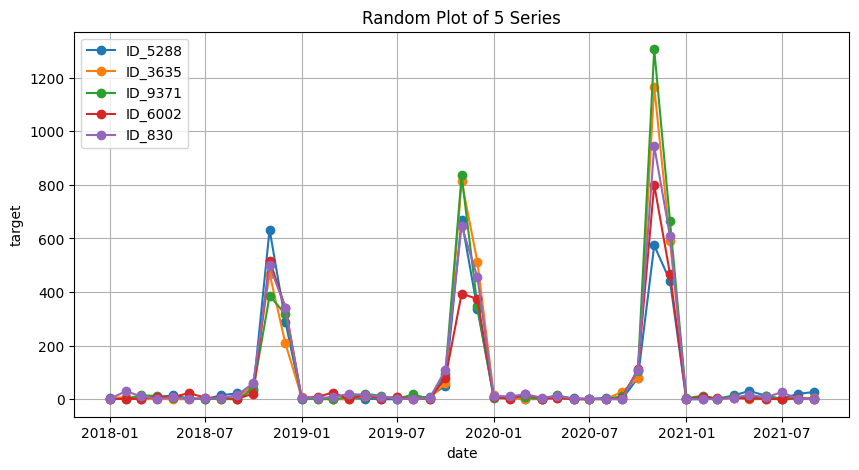

In [6]:
def plot_multiple_series(df, list_of_ids=None, n=10):

    unique_ids = df['ID'].unique()
    if list_of_ids is not None and len(list_of_ids) > 0:
        chosen_ids = list_of_ids[:n]  
    else:
        if len(unique_ids) <= n:
            chosen_ids = unique_ids
        else:
            chosen_ids = np.random.choice(unique_ids, size=n, replace=False)
    
    df_sorted = df.sort_values(by='date').copy()
    
    plt.figure(figsize=(10, 5))
    
    for series_id in chosen_ids:
        subset = df_sorted[df_sorted['ID'] == series_id]
        plt.plot(
            subset['date'], 
            subset['target'], 
            marker='o', 
            label=str(series_id)
        )
    
    plt.title(f"Random Plot of {len(chosen_ids)} Series")
    plt.xlabel("date")
    plt.ylabel("target")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
plot_multiple_series(df, list_of_ids=None, n=5)

In [7]:
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by 'ID' and 'date'
df = df.sort_values(['ID', 'date'])

# Define the number of test periods
n_test = 12

# Split into train and test sets
df_train = df.groupby('ID').apply(lambda x: x.iloc[:-n_test]).reset_index(drop=True)
df_test = df.groupby('ID').apply(lambda x: x.iloc[-n_test:]).reset_index(drop=True)

print("Training Set Shape:", df_train.shape)
print("Testing Set Shape:", df_test.shape)

/var/tmp/ipykernel_95237/1805504897.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df.groupby('ID').apply(lambda x: x.iloc[:-n_test]).reset_index(drop=True)


Training Set Shape: (330000, 3)
Testing Set Shape: (120000, 3)


/var/tmp/ipykernel_95237/1805504897.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test = df.groupby('ID').apply(lambda x: x.iloc[-n_test:]).reset_index(drop=True)


In [ ]:
# df_train.head(100)

In [8]:
train_time_series_data = TimeSeriesDataFrame.from_data_frame(df_train, id_column='ID', timestamp_column='date')
predictor = TimeSeriesPredictor(
        prediction_length=12,  
        target='target',
        eval_metric='RMSE',
        freq='MS',
    )

# predictor.fit(train_time_series_data,
#     presets='chronos_large',
#     hyperparameters={
#         'Chronos': {
#             'model_path': 'large',
#             'batch_size': 32,
#             'device': 'cuda',
#                 # 'data_loader_num_workers': 64,
#                 # 'optimization_strategy': 'openvino',
#             }
#         },
#         skip_model_selection=True,          
#     )
predictor.fit(train_time_series_data,
    hyperparameters={
        'Chronos': {
            'model_path': 'bolt_base',
            # 'fine_tune': True,
            'batch_size': 32,
            'device': 'cuda',
                # 'data_loader_num_workers': 64,
                # 'optimization_strategy': 'openvino',
            }
        },
        skip_model_selection=True,          
    )
# predictor.persist()
forecast_chronos = predictor.predict(train_time_series_data).reset_index()

Beginning AutoGluon training...
AutoGluon will save models to '/home/jupyter/llm/AutogluonModels/ag-20241228_002725'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.226-1 (2024-10-03)
CPU Count:          8
GPU Count:          1
Memory Avail:       27.49 GB / 29.39 GB (93.5%)
Disk Space Avail:   136.51 GB / 294.23 GB (46.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'MS',
 'hyperparameters': {'Chronos': {'batch_size': 32,
                                 'device': 'cuda',
                                 'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 12,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'v

In [9]:
forecast_chronos.to_csv('/home/jupyter/llm/seasonal_intermittent_simulation_chronosboltbase.csv', index= False)

In [10]:
# TimesFM forecast
df_train_tfm = df_train.rename(columns={
    'ID': 'unique_id',
    'date': 'ds',
    'target': 'values'
})
tfm = tfm.TimesFm(
      hparams=tfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=12,
      ),
      checkpoint=tfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m"),
  )
tfm._median_index = -1 
forecast_tfm = tfm.forecast_on_df(
        inputs=df_train_tfm,
        freq='MS',
        num_jobs=-1, 
    )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

2024-12-28 00:28:29.364170: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.6.85). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Multiprocessing context has already been set.
Constructing model weights.


Constructed model weights in 3.59 seconds.
Restoring checkpoint from /home/jupyter/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.97 seconds.
Jitting decoding.
Jitted decoding in 18.89 seconds.
Processing dataframe with multiple processes.


/opt/conda/envs/llm_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Finished preprocessing dataframe.
Finished forecasting.


In [11]:
forecast_tfm.to_csv('/home/jupyter/llm/seasonal_intermittent_simulation_tfm.csv', index= False)

In [12]:
forecast_chronos = pd.read_csv('/home/jupyter/llm/seasonal_intermittent_simulation_chronosboltbase.csv')
forecast_tfm = pd.read_csv('/home/jupyter/llm/seasonal_intermittent_simulation_tfm.csv')

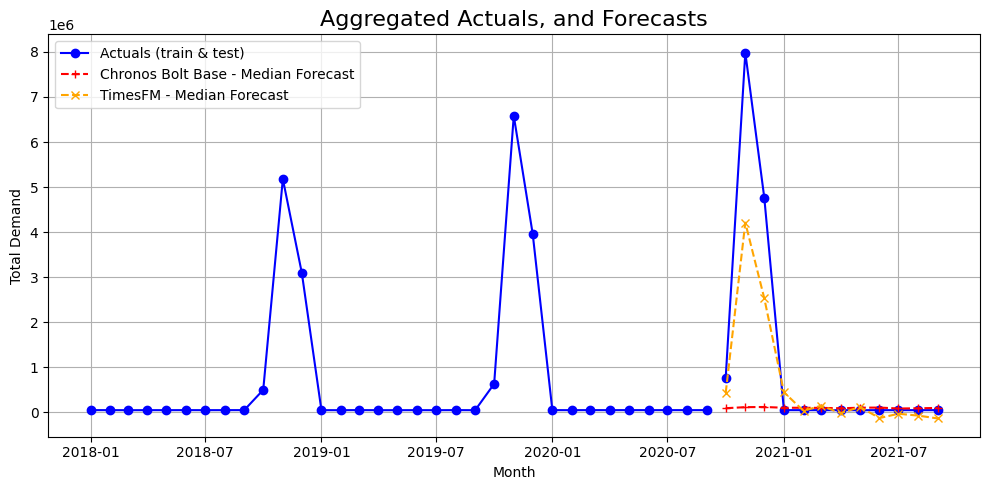

In [13]:
# Ensure that 'date' columns are in datetime format
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# For forecast_chronos
forecast_chronos['timestamp'] = pd.to_datetime(forecast_chronos['timestamp'])
forecast_chronos_renamed = forecast_chronos.rename(columns={
    'item_id': 'ID',
    'timestamp': 'date',
    '0.5': 'chronos_forecast'
})

# For forecast_tfm
forecast_tfm['ds'] = pd.to_datetime(forecast_tfm['ds'])
forecast_tfm_renamed = forecast_tfm.rename(columns={
    'unique_id': 'ID',
    'ds': 'date',
    'timesfm-q-0.5': 'tfm_forecast'
})



# Merge Chronos forecast with df_test
merged_chronos = pd.merge(df_test, forecast_chronos_renamed[['ID', 'date', 'chronos_forecast']],
                          on=['ID', 'date'], how='left')

# Merge TFM forecast with df_test
merged_tfm = pd.merge(df_test, forecast_tfm_renamed[['ID', 'date', 'tfm_forecast']],
                      on=['ID', 'date'], how='left')


test_agg = df_test.groupby('date')['target'].sum().reset_index()

# Aggregate forecasts by date (sum across all IDs)
forecast_chronos_agg = merged_chronos.groupby('date')['chronos_forecast'].sum().reset_index()
forecast_tfm_agg = merged_tfm.groupby('date')['tfm_forecast'].sum().reset_index()


# Aggregate df_train by date (sum across all IDs)
train_agg = df_train.groupby('date')['target'].sum().reset_index()


plt.figure(figsize=(10, 5))

# Plot Aggregated Historical Data (Train) and Actuals (Test) in the same color
plt.plot(train_agg['date'], train_agg['target'], label='Actuals (train & test)', color='blue', marker='o')
plt.plot(test_agg['date'], test_agg['target'], color='blue', marker='o')

# Plot Aggregated Forecasts
plt.plot(forecast_chronos_agg['date'], forecast_chronos_agg['chronos_forecast'],
         label=f'Chronos Bolt Base - Median Forecast',
         color='red', linestyle='--', marker='+')
plt.plot(forecast_tfm_agg['date'], forecast_tfm_agg['tfm_forecast'],
         label=f'TimesFM - Median Forecast',
         color='orange', linestyle='--', marker='x')


# Formatting the x-axis to show months
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
# plt.xticks(rotation=45)

# Adding titles and labels
plt.title("Aggregated Actuals, and Forecasts", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Total Demand")

# Adding legend
plt.legend()

# Adding grid for better readability
plt.grid(True)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Display the plot
plt.show()

In [14]:
def plot_forecasts_for_id(id, df_train, df_test, merged_chronos, merged_tfm):
    
    
    # Historical (Train) Data
    df_train_id = df_train[df_train['ID'] == id]
    
    # Actual Test Data
    df_test_id = df_test[df_test['ID'] == id]
    
    # Chronos Forecast Data
    merged_chronos_id = merged_chronos[merged_chronos['ID'] == id]
    
    # TFM Forecast Data
    merged_tfm_id = merged_tfm[merged_tfm['ID'] == id]
    

    
    # Ensure that there are matching dates
    common_dates = df_test_id['date'].isin(merged_chronos_id['date']) & \
                   df_test_id['date'].isin(merged_tfm_id['date']) 
    
    if not common_dates.all():
        print(f"Warning: Some dates in df_test for {id} are missing in the forecasts.")
    
    # Actual Values
    actuals = df_test_id['target'].values
    
    # Forecasted Values
    chronos_forecast = merged_chronos_id['chronos_forecast'].values
    tfm_forecast = merged_tfm_id['tfm_forecast'].values

    
    
    # Aggregated Historical Data
    train_agg = df_train_id.groupby('date')['target'].sum().reset_index()
    
    # Aggregated Actuals
    test_agg = df_test_id.groupby('date')['target'].sum().reset_index()
    
    # Aggregated Forecasts
    forecast_chronos_agg = merged_chronos_id.groupby('date')['chronos_forecast'].sum().reset_index()
    forecast_tfm_agg = merged_tfm_id.groupby('date')['tfm_forecast'].sum().reset_index()
    

    
    plt.figure(figsize=(14, 7))
    
    # Plot Historical Data (Train)
    plt.plot(train_agg['date'], train_agg['target'], label='Historical (Train)', color='blue')
    
    # Plot Actual Test Data
    plt.plot(test_agg['date'], test_agg['target'], label='Actuals (Test)', color='blue', marker='o')
    
    # Plot Chronos Forecast
    plt.plot(forecast_chronos_agg['date'], forecast_chronos_agg['chronos_forecast'],
             label=f'Chronos Forecast',
             color='red', linestyle='--', marker='x')
    
    # Plot TFM Forecast
    plt.plot(forecast_tfm_agg['date'], forecast_tfm_agg['tfm_forecast'],
             label=f'TFM Forecast',
             color='orange', linestyle='--', marker='x')
    
    
    # Formatting the x-axis to show months
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.xticks(rotation=45)
    
    # Adding titles and labels
    plt.title(f"Aggregated Demand Forecast for {id}", fontsize=16)
    plt.xlabel("Month")
    plt.ylabel("Total Demand")
    
    # Adding legend
    plt.legend()
    
    # Adding grid for better readability
    plt.grid(True)
    
    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()
    
    # Display the plot
    plt.show()


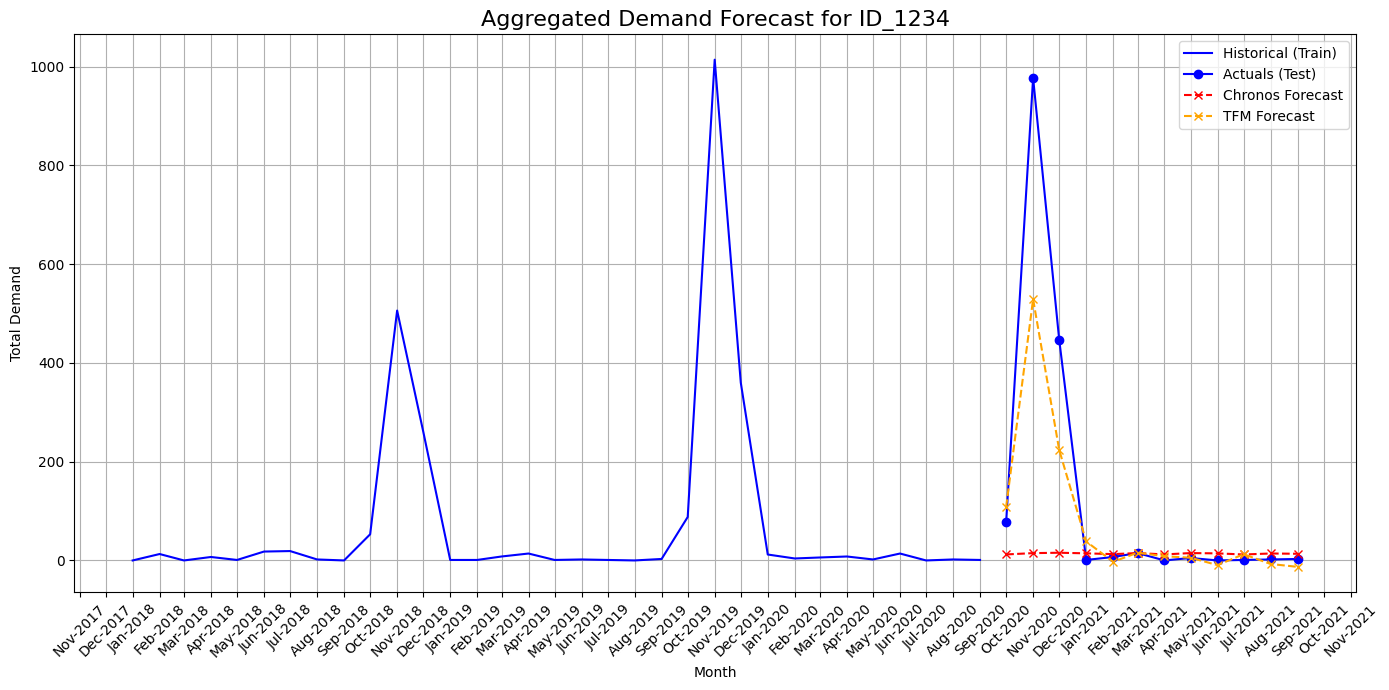

In [15]:
# Example ID to plot
specific_id = 'ID_1234'

# Call the plotting function
plot_forecasts_for_id(specific_id, df_train, df_test, merged_chronos, merged_tfm)
